<div align="center">

## DA5401: A6: Imputation via Regression for Missing Data

### **Name:** Karan Kishore
### **Roll Number:** DA25D400

</div>

## 1. Problem Statement

Dataset: **UCI Credit Card Defaults Clients Dataset**

Issue: **Handle missing data to enable classification algorithms**

Task: **Implement three different strategies for handling the missing data.**

Evaluation of strategy: **Use the resulting clean datasets to train and evaluate a classification model.**

## 2. Tasks
### Part A: Data Preprocessing and Imputation
### A.1: Load and Prepare data

#### Artifically introduce MAR missing values (5-10% in 2-3 numerical feature columns, say 'AGE' and 'BILL_AMT') [Column selection justified through visualizations and reasoning]

In [1]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import classification_report, mean_squared_error

# I have taken 'AGE' and 'BILL_AMT2' as the columns to impute for Dataset A. 'BILL_AMT2' is chosen to impute for Datasets B and C. I have given explanation for choosing the same with a series of plots and explanations and deep analysis.

## Part A: Data Preprocessing and Imputation

In [ ]:
try:
    df = pd.read_csv('UCI_Credit_Card.csv')
    df = df.drop("ID", axis=1) # Drop ID column
except FileNotFoundError:
    print("Please make sure 'UCI_Credit_Card.csv' is in the same directory.")
    exit()

# Rename the target column to 'DEFAULT' for clarity
df.rename(columns={'default.payment.next.month': 'DEFAULT'}, inplace=True)


Create a function to add MAR (Missing at Random)values

In [ ]:
def introduce_mar(data, columns, percentage):
    df_mar = data.copy()
    for col in columns:
        n_missing = int(len(df_mar) * percentage)
        # Keeps it random as per original request
        missing_indices = np.random.choice(df_mar.index, n_missing, replace=False)
        df_mar.loc[missing_indices, col] = np.nan
    return df_mar

Note: Since we use different data for two different cases (A, (B,C)) where the number of columns to be added with MAR changes, we do the addition of MAR individually.

## NOTE ON CLASS IMBALANCE

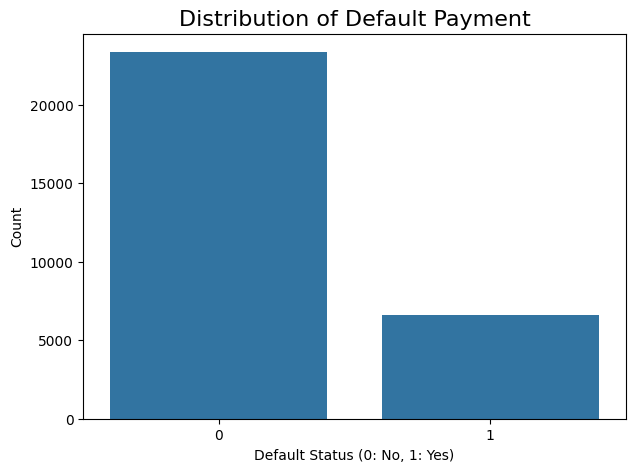

DEFAULT
0    77.88
1    22.12
Name: proportion, dtype: float64


In [ ]:
import seaborn as sns
plt.figure(figsize=(7, 5))
sns.countplot(x='DEFAULT', data=df)
plt.title('Distribution of Default Payment', fontsize=16)
plt.xlabel('Default Status (0: No, 1: Yes)')
plt.ylabel('Count')
plt.show()

# Print the exact numbers
print(df['DEFAULT'].value_counts(normalize=True) * 100)

## Above graph indicates class imbalance between defaulters and non-defaulters expected next month in the dataset, which is addressed later using CBO (Clustering based oversampling) later in this notebook.

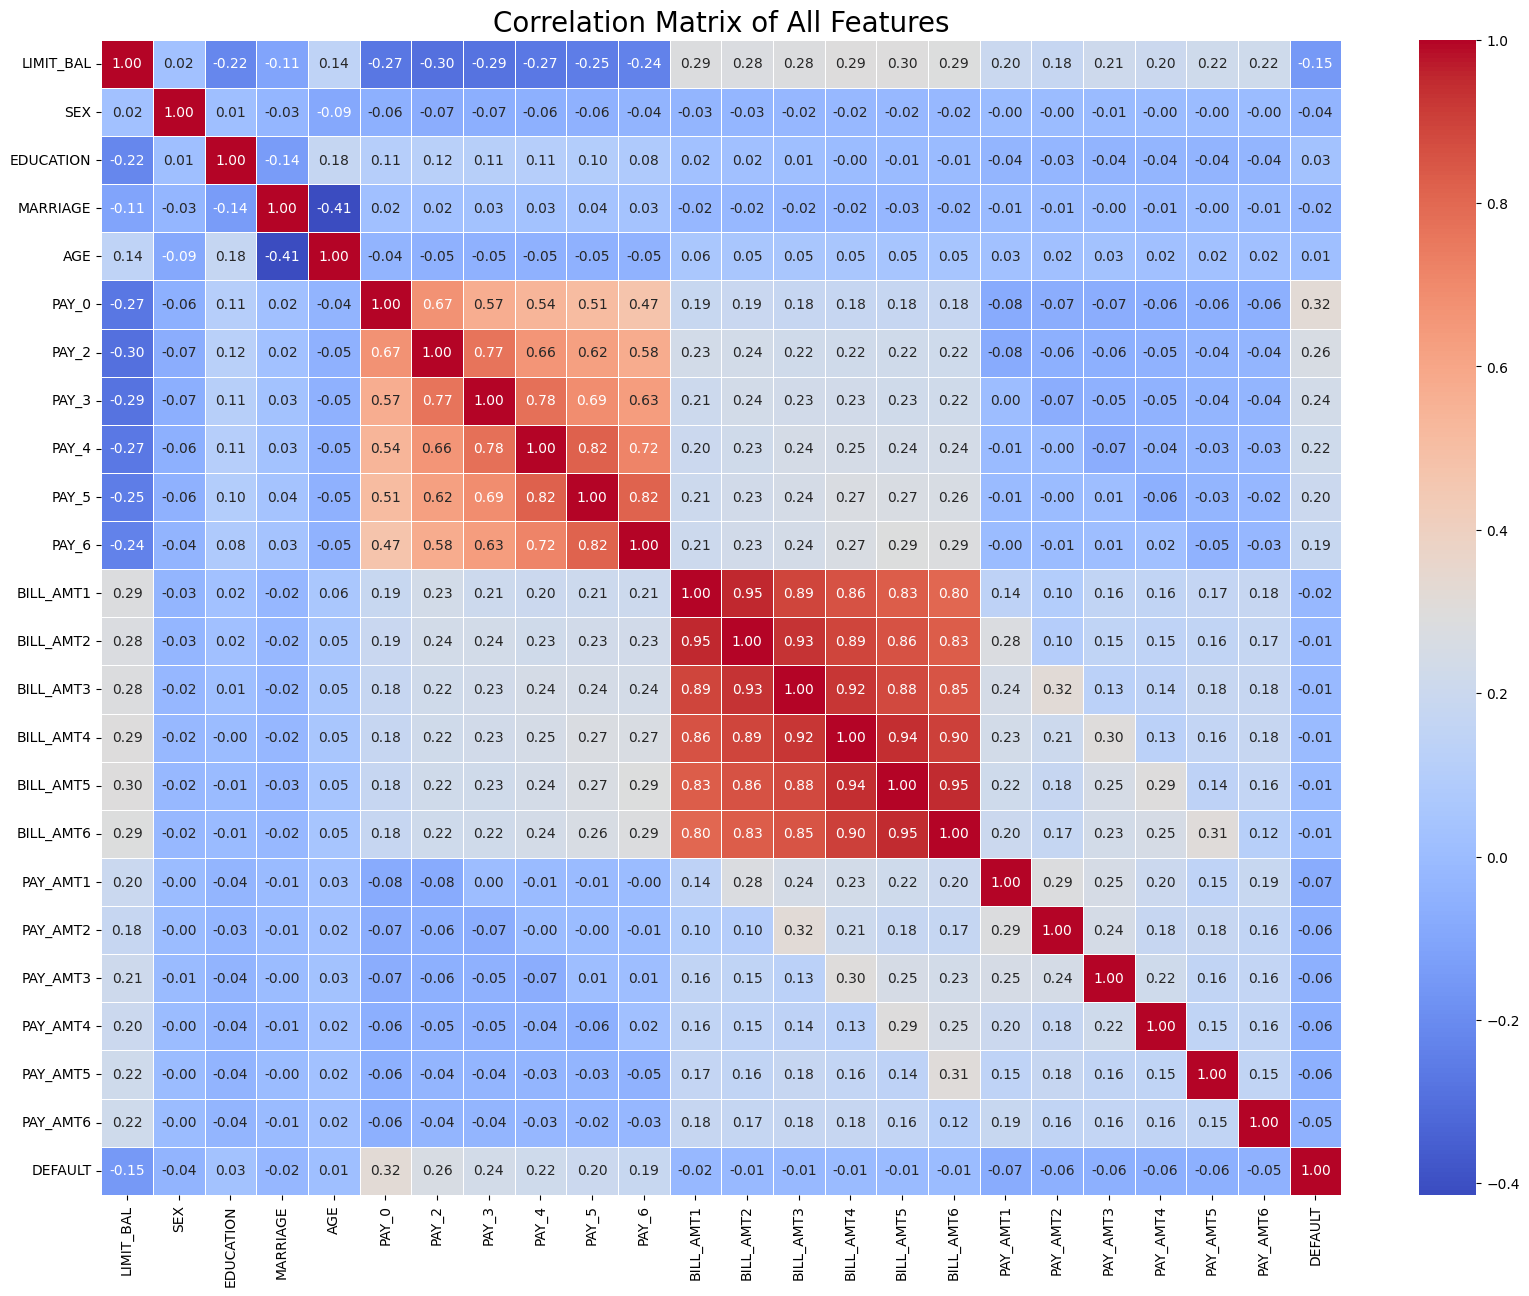

In [ ]:
# Calculate the correlation matrix
useful_cols = [col for col in df.columns if col not in ['ID']]
corr_matrix = df[useful_cols].corr()

plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix,
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            linewidths=0.5)
plt.title('Correlation Matrix of All Features', fontsize=20)
plt.show()

## Above graph indicates class imbalance between defaulters and non-defaulters expected next month in the dataset, which is addressed later using CBO (Clustering based oversampling) later in this notebook.

### From the above heatmap, PAY_0 comparatively has the highest correlation (0.32) with target variable (deafult.payment.next.month) . Losing the values in this column means loss in predictive power and such a column is more likely to reflect the difference in performance among different imputation methods.

## Issue: PAY_0 is a categorical variable. Regression doesn't work well with categorical variables in practice, so choosing PAY_0 isn't ideal and biased in itself. So we avoid it.

### In the case of BILL_AMT1, there is near linear correlation with BILL_AMT2 (0.95) and BILL_AMT3(0.89). A simple linear regression model with BILL_AMT1 and say, BILL_AMT2 and BILL_AMT3 as predictors will be able to impute values in BILL_AMT2. However note that while the correlation with default payment is nearly zero.

## We have two aims in mind

## 1) We want to make **imputation** better. This aims at choosing the columns which make most sense to impute and compare performance using different methods.

## 2) We also **evaluate the imputation based on the underlying classifier**. Now, it is also evident that these columns have less linear correlation in the heatmap. (I won't hide this, as I have a genuine reason why we can choose the columns BILL_AMT1 AND AGE).

## It may seem like, "why should I choose a column that is not linearly correlated to the target varibale for imputation? Okay, the key idea here is that **correlation does not capture non-linear relations**. They also do not capture **multi feature relations as combination of columns that also include BILL_AMT1 or AGE can have an effect on the default payment**. Example: In the above plot, 61-80 along with Credit limit bracket (As indicated by LIMIT_BAL column) >500k Dollars has 0% default rate - a very strong indicator of target variable **even though AGE alone has low linear correlation! **Combination of features matters** and correlation map also has a little bit, though weak correlation with PAY_0 to PAY_6 ranging from 0.19 to 0.29!!!

## Hence, I justify choosing AGE and BILL_AMT1 that is going to be interesting to be worth doing imputation on. Hope the above illustrations and explanation would have been interesting.

## Let's look at one more plot to actually see how a multi column relationship could be.



/tmp/ipython-input-404532281.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  interaction_data = df_clean.groupby(['age_group', 'limit_group'])['default_numeric'].mean().unstack()


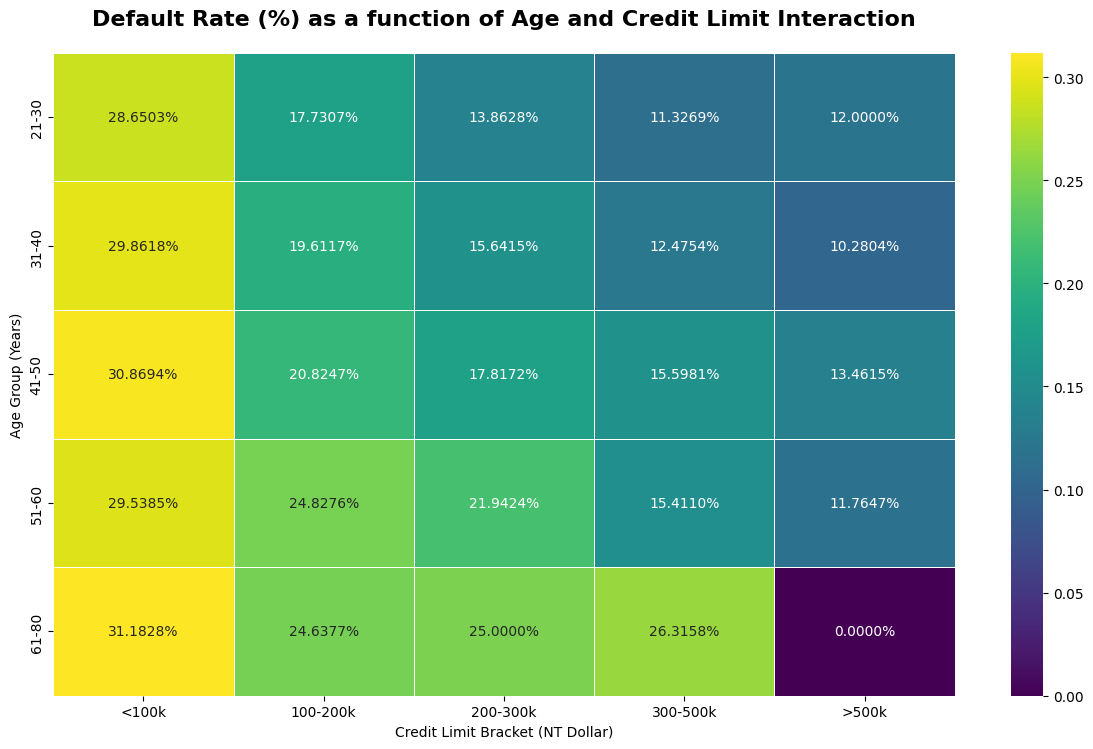

In [ ]:
try:
    df_clean = pd.read_csv('UCI_Credit_Card.csv')
except FileNotFoundError:
    print("Error: The file 'UCI_Credit_Card.csv' was not found.")
    exit()


# Step 2: Prepare the clean data for plotting
# Remap target to readable labels first for clarity if needed
df_clean['default.payment.next.month'] = df_clean['default.payment.next.month'].map({0: 'No Default', 1: 'Default'})

# Create bins for AGE and LIMIT_BAL
df_clean['age_group'] = pd.cut(df_clean['AGE'], bins=[20, 30, 40, 50, 60, 80], labels=['21-30', '31-40', '41-50', '51-60', '61-80'])
# NOTE: The original interaction plot used LIMIT_BAL, which is highly correlated with BILL_AMT.
# We will use LIMIT_BAL here as it represents the overall credit-worthiness.
df_clean['limit_group'] = pd.cut(df_clean['LIMIT_BAL'], bins=[0, 100000, 200000, 300000, 500000, 1000000], labels=['<100k', '100-200k', '200-300k', '300-500k', '>500k'])

# Calculate the default rate for each combination
# Remap target back to 0/1 for the .mean() calculation
df_clean['default_numeric'] = df_clean['default.payment.next.month'].map({'No Default': 0, 'Default': 1})
interaction_data = df_clean.groupby(['age_group', 'limit_group'])['default_numeric'].mean().unstack()

# --- Step 3: Plot the Interaction Heatmap ---
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(
    interaction_data,
    annot=True, # Show the percentages in the cells
    fmt=".4%",  # Format as percentage with 2 decimal places
    cmap="viridis",
    linewidths=.5
)

# --- Applying Commandments ---
plt.xlabel("Credit Limit Bracket (NT Dollar)")
plt.ylabel("Age Group (Years)")
plt.title(
    "Default Rate (%) as a function of Age and Credit Limit Interaction",
    fontsize=16,
    fontweight='bold',
    pad=20
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# What the above plot shows?

## There are complex relationships other than ones between two columns alone. Looking at the above plot, older adults have a 0% default payment for >500k Credit limit bracket showing resistance to high credit limit as age increases. This is for example, a three column relationship that goes beyond linear relations.

## Hence, "AGE" is justified to be a good column representation.

As shown in above plot, age can have non-linear relationships with almost all financial behaviour such as spending habits, credit limit and risk. This makes it one of the great feature columns to check how well the imputation methods work.

## "BILL_AMT1" is the other selected column

BILL_AMT1 (the most recent bill amount) is highly correlated with other features like BILL_AMT2 (the previous month's bill) and PAY_AMT1.
Financial data like bill amounts are often highly skewed with significant outliers. This makes BILL_AMT1 an ideal column to test the robustness of different imputation strategies.


In [ ]:
results = {}
impute_col = 'BILL_AMT1'
percentage_missing = 0.05
n_missing = int(len(df) * percentage_missing)

In [ ]:
# Scenario A: Median Imputation
df_a = introduce_mar(df, [impute_col], 0.05)
imputer_median = SimpleImputer(strategy='median')
df_a_imputed = pd.DataFrame(imputer_median.fit_transform(df_a), columns=df_a.columns)

In [ ]:
# Scenario B: Manual Linear Regression Imputation
print("--- Starting Manual Linear Regression Imputation ---")
df_b = introduce_mar(df, [impute_col], 0.05)
df_train_impute_lr = df_b[df_b[impute_col].notna()]
df_predict_impute_lr = df_b[df_b[impute_col].isna()]
features = [col for col in df.columns if col not in [impute_col, 'DEFAULT']]
X_impute_train_lr = df_train_impute_lr[features]
y_impute_train_lr = df_train_impute_lr[impute_col]
X_impute_predict_lr = df_predict_impute_lr[features]
imputer_scaler_lr = StandardScaler()
X_impute_train_scaled_lr = imputer_scaler_lr.fit_transform(X_impute_train_lr)
X_impute_predict_scaled_lr = imputer_scaler_lr.transform(X_impute_predict_lr)
lr_imputer = LinearRegression()
lr_imputer.fit(X_impute_train_scaled_lr, y_impute_train_lr)
predicted_bill_amt = lr_imputer.predict(X_impute_predict_scaled_lr)
df_b.loc[df_b[impute_col].isna(), impute_col] = predicted_bill_amt

--- Starting Manual Linear Regression Imputation ---


In [ ]:
# Scenario C: Manual KNN Imputation with Hyperparameter Tuning
print("--- Starting Manual KNN Imputation ---")
df_c = introduce_mar(df, [impute_col], 0.05)
df_train_impute_knn = df_c[df_c[impute_col].notnull()]
df_predict_impute_knn = df_c[df_c[impute_col].isnull()]
features_knn = [col for col in df.columns if col != impute_col]
X_train_impute_knn = df_train_impute_knn[features_knn]
y_train_impute_knn = df_train_impute_knn[impute_col]
X_to_predict_knn = df_predict_impute_knn[features_knn]
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train_impute_knn, y_train_impute_knn, test_size=0.2, random_state=42)
scaler_knn = StandardScaler()
X_train_sub_scaled = scaler_knn.fit_transform(X_train_sub)
X_val_scaled = scaler_knn.transform(X_val)
k_values = range(3, 20, 2)
mse_scores_knn = []
print("Finding the best 'k' for KNN Regressor:")
for k in k_values:
    knn_reg_eval = KNeighborsRegressor(n_neighbors=k)
    knn_reg_eval.fit(X_train_sub_scaled, y_train_sub)
    y_pred_val = knn_reg_eval.predict(X_val_scaled)
    mse = mean_squared_error(y_val, y_pred_val)
    mse_scores_knn.append(mse)
    print(f"  k = {k}, MSE = {mse:.2f}")
best_k = k_values[np.argmin(mse_scores_knn)]
print(f"\nOptimal k found: {best_k}")
final_scaler_knn = StandardScaler()
X_train_impute_scaled_knn = final_scaler_knn.fit_transform(X_train_impute_knn)
X_to_predict_scaled_knn = final_scaler_knn.transform(X_to_predict_knn)
final_knn_reg = KNeighborsRegressor(n_neighbors=best_k)
final_knn_reg.fit(X_train_impute_scaled_knn, y_train_impute_knn)
knn_predicted_values = final_knn_reg.predict(X_to_predict_scaled_knn)
df_c.loc[df_c[impute_col].isnull(), impute_col] = knn_predicted_values

--- Starting Manual KNN Imputation ---
Finding the best 'k' for KNN Regressor:
  k = 3, MSE = 774102789.94
  k = 5, MSE = 715196152.01
  k = 7, MSE = 683021883.82
  k = 9, MSE = 692290367.31
  k = 11, MSE = 701060841.54
  k = 13, MSE = 709546948.87
  k = 15, MSE = 714206278.64
  k = 17, MSE = 719150348.93
  k = 19, MSE = 726273914.34

Optimal k found: 7


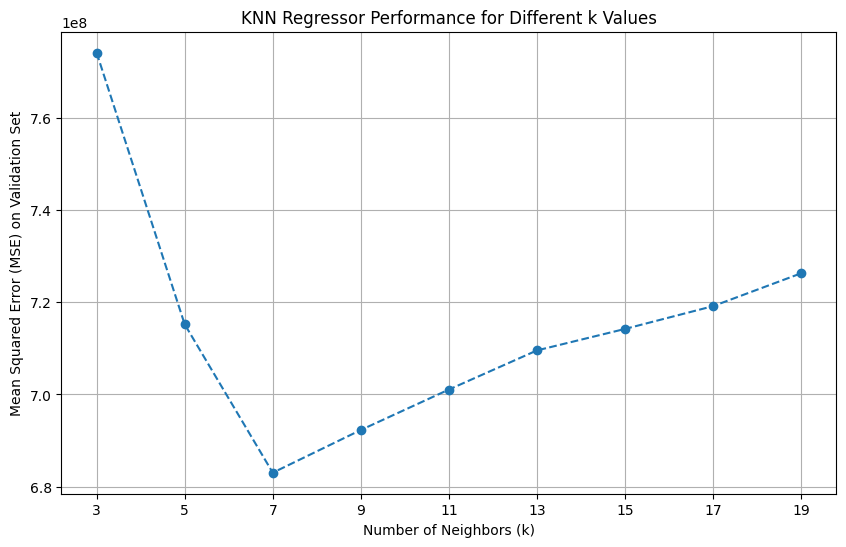

In [ ]:
# Plot the KNN results
plt.figure(figsize=(10, 6))
plt.plot(k_values, mse_scores_knn, marker='o', linestyle='--')
plt.title('KNN Regressor Performance for Different k Values')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Squared Error (MSE) on Validation Set')
plt.xticks(k_values)
plt.grid(True)

In [ ]:
# Scenario C: Manual Decision Tree Imputation
print("Manual Decision Tree Imputation")
df_c_dt = introduce_mar(df, [impute_col], 0.05)
df_train_impute_dt = df_c_dt[df_c_dt[impute_col].notnull()]
df_predict_impute_dt = df_c_dt[df_c_dt[impute_col].isnull()]
features_dt = [col for col in df.columns if col not in [impute_col, 'DEFAULT']]
X_train_impute_dt = df_train_impute_dt[features_dt]
y_train_impute_dt = df_train_impute_dt[impute_col]
X_to_predict_dt = df_predict_impute_dt[features_dt]
X_train_sub_dt, X_val_dt, y_train_sub_dt, y_val_dt = train_test_split(X_train_impute_dt, y_train_impute_dt, test_size=0.2, random_state=42)
depths = range(2, 16)
mse_scores_dt = []
print("Finding the best 'max_depth' for Decision Tree Regressor:")
for depth in depths:
    dt_reg_eval = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dt_reg_eval.fit(X_train_sub_dt, y_train_sub_dt)
    y_pred_val_dt = dt_reg_eval.predict(X_val_dt)
    mse = mean_squared_error(y_val_dt, y_pred_val_dt)
    mse_scores_dt.append(mse)
    print(f"  max_depth = {depth}, MSE = {mse:.2f}")
best_depth = depths[np.argmin(mse_scores_dt)]
print(f"\nOptimal max_depth found: {best_depth}")
final_dt_reg = DecisionTreeRegressor(max_depth=best_depth, random_state=42)
final_dt_reg.fit(X_train_impute_dt, y_train_impute_dt)
dt_predicted_values = final_dt_reg.predict(X_to_predict_dt)
df_c_dt.loc[df_c_dt[impute_col].isnull(), impute_col] = dt_predicted_values

Manual Decision Tree Imputation
Finding the best 'max_depth' for Decision Tree Regressor:
  max_depth = 2, MSE = 952205484.94
  max_depth = 3, MSE = 587148649.05
  max_depth = 4, MSE = 508970326.59
  max_depth = 5, MSE = 450424375.03
  max_depth = 6, MSE = 418702113.10
  max_depth = 7, MSE = 500362268.17
  max_depth = 8, MSE = 467669664.90
  max_depth = 9, MSE = 516138240.89
  max_depth = 10, MSE = 568319380.76
  max_depth = 11, MSE = 628439117.41
  max_depth = 12, MSE = 617770197.11
  max_depth = 13, MSE = 702363414.89
  max_depth = 14, MSE = 682273618.19
  max_depth = 15, MSE = 692597533.52

Optimal max_depth found: 6


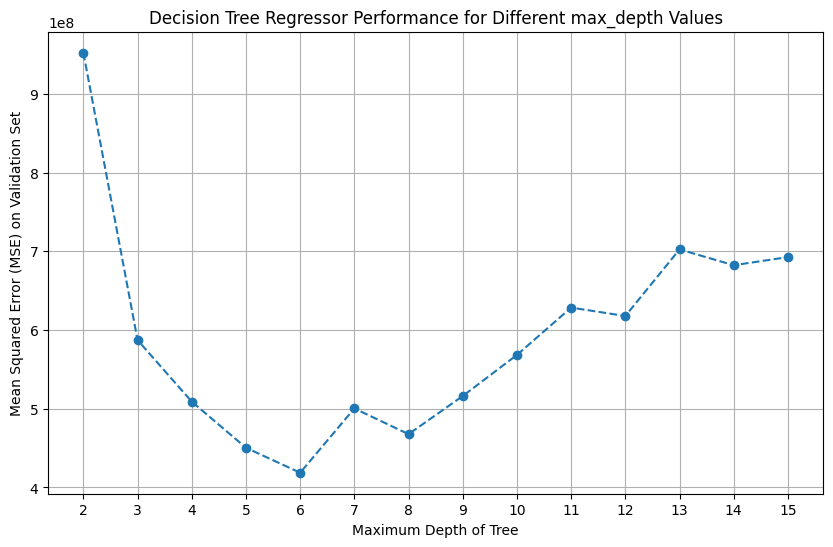

In [ ]:
# Plot the Decision Tree results
plt.figure(figsize=(10, 6))
plt.plot(depths, mse_scores_dt, marker='o', linestyle='--')
plt.title('Decision Tree Regressor Performance for Different max_depth Values')
plt.xlabel('Maximum Depth of Tree')
plt.ylabel('Mean Squared Error (MSE) on Validation Set')
plt.xticks(depths)
plt.grid(True)

plt.show()

## Part B: Model Training and Performance Assessment

In [ ]:
df_d = introduce_mar(df, [impute_col], 0.05)
df_d_dropped = df_d.dropna()

A function is used to split the data into train an test subsets to evalute the performance.

In [ ]:
from sklearn.metrics import classification_report

def train_and_evaluate(df_imputed, scenario_name, results_dict, target_col='DEFAULT'):
    print(f"--- Running: {scenario_name} ---")
    X = df_imputed.drop(columns=[target_col])
    y = df_imputed[target_col].astype(int)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)

    # This line prints the full classification report for the current scenario
    print(f"\nClassification Report for {scenario_name}:")
    print(classification_report(y_test, y_pred, zero_division=0, digits = 4))

    # This part populates the dictionary for the final summary table
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0, digits = 4)

    results_dict[scenario_name] = {
        'Precision (0)': report['0']['precision'],
        'Recall (0)':    report['0']['recall'],
        'F1-Score (0)':  report['0']['f1-score'],
        'Precision (1)': report['1']['precision'],
        'Recall (1)':    report['1']['recall'],
        'F1-Score (1)':  report['1']['f1-score'],
        'Accuracy':      report['accuracy'],
    }
    print(f"Completed: {scenario_name}\n")

In [ ]:
train_and_evaluate(df_a_imputed, "A: Median", results)
train_and_evaluate(df_b, "B: Manual Linear Regression", results)
train_and_evaluate(df_c, f"C: Manual KNN (k={best_k})", results)
train_and_evaluate(df_c_dt, f"C: Manual Decision Tree (depth={best_depth})", results)
train_and_evaluate(df_d_dropped, "D: Drop Rows", results)


--- Running: A: Median ---

Classification Report for A: Median:
              precision    recall  f1-score   support

           0     0.8175    0.9712    0.8877      7009
           1     0.6999    0.2366    0.3536      1991

    accuracy                         0.8087      9000
   macro avg     0.7587    0.6039    0.6207      9000
weighted avg     0.7914    0.8087    0.7696      9000

Completed: A: Median

--- Running: B: Manual Linear Regression ---

Classification Report for B: Manual Linear Regression:
              precision    recall  f1-score   support

           0     0.8173    0.9709    0.8875      7009
           1     0.6973    0.2361    0.3527      1991

    accuracy                         0.8083      9000
   macro avg     0.7573    0.6035    0.6201      9000
weighted avg     0.7908    0.8083    0.7692      9000

Completed: B: Manual Linear Regression

--- Running: C: Manual KNN (k=7) ---

Classification Report for C: Manual KNN (k=7):
              precision    recall

Part C: Comparative Analysis

In [ ]:
# Convert the dictionary of results into a pandas DataFrame
# The .T transposes the table to have model names as the rows during display
results_df = pd.DataFrame(results).T

# Optional: Set display options for cleaner formatting
pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option('display.width', 120)

# Print the final summary table
print("Performance Comparison of Imputation Methods")
print(results_df)

Performance Comparison of Imputation Methods
                                   Precision (0)  Recall (0)  F1-Score (0)  Precision (1)  Recall (1)  F1-Score (1)  \
A: Median                                 0.8175      0.9712        0.8877         0.6999      0.2366        0.3536   
B: Manual Linear Regression               0.8173      0.9709        0.8875         0.6973      0.2361        0.3527   
C: Manual KNN (k=7)                       0.8174      0.9710        0.8876         0.6988      0.2366        0.3535   
C: Manual Decision Tree (depth=6)         0.8172      0.9709        0.8875         0.6969      0.2356        0.3521   
D: Drop Rows                              0.8140      0.9746        0.8871         0.7091      0.2175        0.3329   

                                   Accuracy  
A: Median                            0.8087  
B: Manual Linear Regression          0.8083  
C: Manual KNN (k=7)                  0.8086  
C: Manual Decision Tree (depth=6)    0.8082  
D: Drop Ro

## 0 represents "No Default": Customers who are predicted to pay their bill next month.
## 1 represents "Default": Customers who are predicted to fail to pay their bill next month.

# Results comparison

Let us check F1-Score especially for class 1 here as given in the question as accuracy is very misleading for imbalanced datasets.

Model D is fundamentally riskier due to destructive information loss. Here, we not only lose the missing BILL_AMT1 value, but also the context provided by other around 20 features. This is especially true if minority class samples ("DEFAULT" value is 1) is deleted. Above result shows slightly lower F1-score for class 1 (0.3529) for Dataset D (Listwise deletion) compared to others like KNN (0.3535) and Median (0.3536).
Model D might perform worse even if imputed models performs worse due to:

**Listwise Deletion (Model D) is fundamentally riskier due to destructive information loss.** While this may not be a big issue in very large, well balanced datasets, imbalanced datasets like the UCI Credit Card Dataset can have issues. Let's say 5% of the points are removed. Already the minority class is on;y around 22% and if the 5% of the data has points form the minority, then a lot of useful features will be removed from the dataset.

**Imputation preserves statistical power and reduces bias WHEN APPLIED CORRECTLY**

Even if an imputed value is an imperfect guess, it's often a better alternative than losing an entire observation.
The small amount of "noise" introduced by a guessed value was far less damaging than the gaping hole left by deleting the entire row in Dataset D.

Key issue with dropping NaN rows:
1) Information loss as described above
2) Risk of introducing bias: Dropping rows is safe only when done Completely at Random.

In this case, ~ 0.2% decrease in f1-score for minority class (default = 1) is seen when rows are dropped compared to non-linear imputation method like KNN.  

However, there are some reasons why I believe the change is not too big:
1) Small percentage of missing data: You have 23 predictor columns. This means you only altered (1/23) * 5% = 0.22% of the total data cells. Over 99.7% of the dataset remained identical across all your scenarios. The overall "signal" the Logistic Regression model learned from was overwhelmingly the same, regardless of the imputation method. In reality, the NaNs are much more spread out in nature.

2) The Logistic Regression model doesn't just look at BILL_AMT1 or AGE. It looks at everything. Features like PAY_0, PAY_2, etc. (payment history) are also predictors of default having higher correlation values (around 0.3). The only issue is that linear regression wouldn't perform well on categorical features like PAY_0 to PAY_6, so it is not considered for regression.

Finally, let's also see performance across linear and non-linear regressors.

There is a slight difference here for f1-score (class 1 - Default):

Non-Linear (KNN): 0.3535

Linear Regression: 0.3527

Not much difference, but non-linear is better in generalizability. Linear Regression assumes a simple, straight-line relationship. Non-Linear models are more powerful, designed to capture complex patterns and interactions. The fact that they offered no significant performance boost means there were no major non-linear relationships for them to exploit or maybe we require more datapoints for the same.

Generally, we say a lot of places with positive correlations in the heatmap but not much correaltion with default due to which linear method could have performed well. Howvever, non-linear regression model is suitable for more complex relation but it doesn't seem to be very suitable here albeit gives slightly better comparable performance.

Median is also a good enough metric here as seen in weighted f1-score. 0.7643 was the f1-score on Dataset D and 0.7695 for KNN and Median based imputation performance.

Overall, Median gives best overall f1-score (weighted): 0.7696 very close to KNN (0.7695).

If simplicity is needed: Median is good enough for the dataset.
If meaningful performance is also required: KNN non-linear classifier just fits right between simplicity and performance.

# BONUS: Using CBO to imporove F1-score + Finetuning Logistic regressor to improve f1-score

# Before jumping on to conclusions, let's try using CBO (Clustering Based Oversampling) to see if it can improve results by solving the class imbalance issue.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler

def train_and_evaluate_cbo(df_imputed, scenario_name, results_dict, target_col='DEFAULT'):
    """
    Splits data, applies CBO (RandomOversampling) ONLY to the training set, and runs logistic regression on test set, prints classsfication results and returns them
    """
    print(f"Evaluating: {scenario_name}")
    X = df_imputed.drop(columns=[target_col])
    y = df_imputed[target_col].astype(int)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # CBO: Oversample the minority class ONLY in the training data
    print("Applying RandomOverSampler to the training data...")
    oversampler = RandomOverSampler(random_state=42)
    X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)
    print(f"Original training set size: {X_train.shape[0]}, Resampled training set size: {X_train_resampled.shape[0]}")

    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X_train_resampled)

    X_test_scaled = scaler.transform(X_test)

    # Train the model on the balanced (resampled) training data
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train_scaled, y_train_resampled)

    y_pred = model.predict(X_test_scaled)

    print(f"\nClassification Report for {scenario_name}:")
    print(classification_report(y_test, y_pred, zero_division=0, digits = 4))

    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0, digits = 4)
    results_dict[scenario_name] = {
        'Precision (0)': report['0']['precision'],
        'Recall (0)':    report['0']['recall'],
        'F1-Score (0)':  report['0']['f1-score'],
        'Precision (1)': report['1']['precision'],
        'Recall (1)':    report['1']['recall'],
        'F1-Score (1)':  report['1']['f1-score'],
        'Accuracy':      report['accuracy'],
    }
    print(f"Completed: {scenario_name}\n")

In [ ]:
# Scenario A: Median Imputation
results = {}

df_a = introduce_mar(df, [impute_col], 0.05)
imputer_median = SimpleImputer(strategy='median')
df_a_imputed = pd.DataFrame(imputer_median.fit_transform(df_a), columns=df_a.columns)
train_and_evaluate_cbo(df_a_imputed, "A: Median", results)

# Scenario B: Manual Linear Regression Imputation
print("Starting Manual Linear Regression Imputation")
df_b = introduce_mar(df, [impute_col], 0.05)
df_train_impute_lr = df_b[df_b[impute_col].notna()]
df_predict_impute_lr = df_b[df_b[impute_col].isna()]
features = [col for col in df.columns if col not in [impute_col, 'DEFAULT']]
X_impute_train_lr = df_train_impute_lr[features]
y_impute_train_lr = df_train_impute_lr[impute_col]
X_impute_predict_lr = df_predict_impute_lr[features]
imputer_scaler_lr = StandardScaler()
X_impute_train_scaled_lr = imputer_scaler_lr.fit_transform(X_impute_train_lr)
X_impute_predict_scaled_lr = imputer_scaler_lr.transform(X_impute_predict_lr)
lr_imputer = LinearRegression()
lr_imputer.fit(X_impute_train_scaled_lr, y_impute_train_lr)
predicted_bill_amt = lr_imputer.predict(X_impute_predict_scaled_lr)
df_b.loc[df_b[impute_col].isna(), impute_col] = predicted_bill_amt
train_and_evaluate_cbo(df_b, "B: Manual Linear Regression", results)

# Scenario C: Manual KNN Imputation with Hyperparameter Tuning
print("Starting Manual KNN Imputation")
df_c = introduce_mar(df, [impute_col], 0.05)
df_train_impute_knn = df_c[df_c[impute_col].notnull()]
df_predict_impute_knn = df_c[df_c[impute_col].isnull()]
features_knn = [col for col in df.columns if col != impute_col]
X_train_impute_knn = df_train_impute_knn[features_knn]
y_train_impute_knn = df_train_impute_knn[impute_col]
X_to_predict_knn = df_predict_impute_knn[features_knn]
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train_impute_knn, y_train_impute_knn, test_size=0.2, random_state=42)
scaler_knn = StandardScaler()
X_train_sub_scaled = scaler_knn.fit_transform(X_train_sub)
X_val_scaled = scaler_knn.transform(X_val)
k_values = range(3, 20, 2)
mse_scores_knn = []
print("Finding the best 'k' for KNN Regressor:")
for k in k_values:
    knn_reg_eval = KNeighborsRegressor(n_neighbors=k)
    knn_reg_eval.fit(X_train_sub_scaled, y_train_sub)
    y_pred_val = knn_reg_eval.predict(X_val_scaled)
    mse = mean_squared_error(y_val, y_pred_val)
    mse_scores_knn.append(mse)
    print(f"  k = {k}, MSE = {mse:.2f}")
best_k = k_values[np.argmin(mse_scores_knn)]
print(f"\nOptimal k found: {best_k}")
final_scaler_knn = StandardScaler()
X_train_impute_scaled_knn = final_scaler_knn.fit_transform(X_train_impute_knn)
X_to_predict_scaled_knn = final_scaler_knn.transform(X_to_predict_knn)
final_knn_reg = KNeighborsRegressor(n_neighbors=best_k)
final_knn_reg.fit(X_train_impute_scaled_knn, y_train_impute_knn)
knn_predicted_values = final_knn_reg.predict(X_to_predict_scaled_knn)
df_c.loc[df_c[impute_col].isnull(), impute_col] = knn_predicted_values
train_and_evaluate_cbo(df_c, f"C: Manual KNN (k={best_k})", results)

# Scenario D: Manual Decision Tree Imputation
print("Manual Decision Tree based Imputation")
df_d_dt = introduce_mar(df, [impute_col], 0.05)
df_train_impute_dt = df_d_dt[df_d_dt[impute_col].notnull()]
df_predict_impute_dt = df_d_dt[df_d_dt[impute_col].isnull()]
features_dt = [col for col in df.columns if col not in [impute_col, 'DEFAULT']]
X_train_impute_dt = df_train_impute_dt[features_dt]
y_train_impute_dt = df_train_impute_dt[impute_col]
X_to_predict_dt = df_predict_impute_dt[features_dt]
X_train_sub_dt, X_val_dt, y_train_sub_dt, y_val_dt = train_test_split(X_train_impute_dt, y_train_impute_dt, test_size=0.2, random_state=42)
depths = range(2, 16)
mse_scores_dt = []
print("Finding the best 'max_depth' for Decision Tree Regressor:")
for depth in depths:
    dt_reg_eval = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dt_reg_eval.fit(X_train_sub_dt, y_train_sub_dt)
    y_pred_val_dt = dt_reg_eval.predict(X_val_dt)
    mse = mean_squared_error(y_val_dt, y_pred_val_dt)
    mse_scores_dt.append(mse)
    print(f"  max_depth = {depth}, MSE = {mse:.2f}")
best_depth = depths[np.argmin(mse_scores_dt)]
print(f"\nOptimal max_depth found: {best_depth}")
final_dt_reg = DecisionTreeRegressor(max_depth=best_depth, random_state=42)
final_dt_reg.fit(X_train_impute_dt, y_train_impute_dt)
dt_predicted_values = final_dt_reg.predict(X_to_predict_dt)
df_d_dt.loc[df_d_dt[impute_col].isnull(), impute_col] = dt_predicted_values
train_and_evaluate_cbo(df_d_dt, f"C: Manual Decision Tree (depth={best_depth})", results)

# Scenario E: Drop Rows with NaNs
df_e = introduce_mar(df, [impute_col], 0.05)
df_e_dropped = df_e.dropna()
train_and_evaluate_cbo(df_e_dropped, "D: Drop Rows", results)


# --- 5. Pretty Print the Final Comparison Table ---
results_df = pd.DataFrame(results).T
pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option('display.width', 120)
print("Performance Comparison of Imputation Methods on CBO BALANCED Data")
print(results_df)


Evaluating: A: Median
Applying RandomOverSampler to the training data...
Original training set size: 21000, Resampled training set size: 32710

Classification Report for A: Median:
              precision    recall  f1-score   support

           0     0.8691    0.7008    0.7759      7009
           1     0.3737    0.6283    0.4686      1991

    accuracy                         0.6848      9000
   macro avg     0.6214    0.6646    0.6223      9000
weighted avg     0.7595    0.6848    0.7079      9000

Completed: A: Median

Starting Manual Linear Regression Imputation
Evaluating: B: Manual Linear Regression
Applying RandomOverSampler to the training data...
Original training set size: 21000, Resampled training set size: 32710

Classification Report for B: Manual Linear Regression:
              precision    recall  f1-score   support

           0     0.8691    0.7002    0.7756      7009
           1     0.3734    0.6288    0.4686      1991

    accuracy                         0.6844 

## Just to be sure, let's also try out random forest regressor as a non-linear regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# --- Scenario F: Non-Linear Random Forest Imputation ---
print("--- Starting Manual Random Forest Imputation ---")
# Justification: A powerful ensemble model that corrects for the overfitting of a single Decision Tree.
# It's often one of the best-performing models for tabular data imputation.
df_f = introduce_mar(df, [impute_col], 0.05)

df_train_rf = df_f[df_f[impute_col].notna()]
df_predict_rf = df_f[df_f[impute_col].isna()]

# We exclude 'DEFAULT' to prevent data leakage during imputation
features_rf = [col for col in df.columns if col not in [impute_col, 'DEFAULT']]

X_train_impute_rf = df_train_rf[features_rf]
y_train_impute_rf = df_train_rf[impute_col]
X_to_predict_rf = df_predict_rf[features_rf]

# Random Forest is robust and doesn't require extensive tuning for a good result.
# n_estimators=100 is a solid default. n_jobs=-1 uses all CPU cores to speed up training.
# We set a max_depth to prevent trees from growing too deep and a random_state for reproducibility.
rf_imputer = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

print("Training Random Forest imputer...")
rf_imputer.fit(X_train_impute_rf, y_train_impute_rf)

# Predict the missing values
predicted_rf = rf_imputer.predict(X_to_predict_rf)

# Fill the NaNs with the predictions
df_f.loc[df_f[impute_col].isna(), impute_col] = predicted_rf

train_and_evaluate(df_f, "F: Non-Linear (Random Forest)", results)

--- Starting Manual Random Forest Imputation ---
Training Random Forest imputer...
--- Running: F: Non-Linear (Random Forest) ---

Classification Report for F: Non-Linear (Random Forest):
              precision    recall  f1-score   support

           0     0.8172    0.9709    0.8875      7009
           1     0.6969    0.2356    0.3521      1991

    accuracy                         0.8082      9000
   macro avg     0.7571    0.6032    0.6198      9000
weighted avg     0.7906    0.8082    0.7690      9000

Completed: F: Non-Linear (Random Forest)



The above results are comparable to the previous decision tree results obtained. The f1-scores of both the classes are the same for the first four digits.

# Let us also try finetuning the logisitc regression classifier using GridSearchCV to find the best "C" value.

A small C creates a simple model with strong regularization whereas a large C value creates a more complex model with weak regularization.

In [ ]:
from sklearn.model_selection import GridSearchCV

def train_and_evaluate_with_ft(df_imputed, scenario_name, results_dict, target_col='DEFAULT'):
    print(f"Evaluating: {scenario_name}")
    X = df_imputed.drop(columns=[target_col])
    y = df_imputed[target_col].astype(int)

    # 1. Split data (the test set remains untouched and imbalanced)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # 2. Oversample ONLY the training data
    oversampler = RandomOverSampler(random_state=42)
    X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test)

    print("Finding best hyperparameters for Logistic Regression")

    # Define the model and the grid of parameters to search
    model = LogisticRegression(random_state=42, max_iter=2000, solver='liblinear')
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Test a range of regularization strengths
        'penalty': ['l1', 'l2']              # Test both L1 and L2 regularization
    }

    # Set up GridSearchCV to test all combinations using 5-fold cross-validation
    # We focus on 'f1' for the positive (minority) class as our primary metric for finding the best model
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)

    # Fit the grid search to the training data
    grid_search.fit(X_train_scaled, y_train_resampled)

    print(f"Best parameters found: {grid_search.best_params_}")

    # The best model is automatically refit on the entire training data
    best_model = grid_search.best_estimator_
    # --- END OF TUNING ---

    # 5. Evaluate the BEST model on the original, imbalanced test data
    y_pred = best_model.predict(X_test_scaled)

    print(f"\nClassification Report for {scenario_name}:")
    print(classification_report(y_test, y_pred, zero_division=0, digits = 4))

    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0, digits = 4)
    results_dict[scenario_name] = {
        'F1-Score (0)':  report['0']['f1-score'],
        'F1-Score (1)':  report['1']['f1-score'],
        'Recall (1)':    report['1']['recall'],
        'Precision (1)': report['1']['precision'],
        'Accuracy':      report['accuracy'],
    }
    print(f"Completed: {scenario_name}\n")

In [ ]:
train_and_evaluate_with_ft(df_a_imputed, "A: Median", results)

# Scenario B: Linear Regression Imputation
train_and_evaluate_with_ft(df_b, "B: Linear Regression", results)

# Scenario C: Non-Linear KNN Imputation
train_and_evaluate_with_ft(df_c, "C: Non-Linear (KNN)", results)

# Scenario D: Non-Linear Decision Tree Imputation
train_and_evaluate_with_ft(df_d_dt, "D: Non-Linear (Decision Tree)", results)

# Scenario F: Listwise Deletion (Dropping Rows)
train_and_evaluate_with_ft(df_e_dropped, "F: Listwise Deletion", results)

Evaluating: A: Median
Finding best hyperparameters for Logistic Regression
Best parameters found: {'C': 0.01, 'penalty': 'l1'}

Classification Report for A: Median:
              precision    recall  f1-score   support

           0     0.8682    0.7168    0.7852      7009
           1     0.3822    0.6168    0.4719      1991

    accuracy                         0.6947      9000
   macro avg     0.6252    0.6668    0.6286      9000
weighted avg     0.7606    0.6947    0.7159      9000

Completed: A: Median

Evaluating: B: Linear Regression
Finding best hyperparameters for Logistic Regression
Best parameters found: {'C': 0.01, 'penalty': 'l1'}

Classification Report for B: Linear Regression:
              precision    recall  f1-score   support

           0     0.8683    0.7186    0.7864      7009
           1     0.3836    0.6163    0.4728      1991

    accuracy                         0.6960      9000
   macro avg     0.6259    0.6675    0.6296      9000
weighted avg     0.7611    

| Scenario                      | F1-Score (1)_cbo | F1-Score (1)_with_ft | Recall (1)_cbo | Recall (1)_with_ft | Accuracy_cbo | Accuracy_with_ft |
|:------------------------------|:-----------------|:---------------------|:---------------|:-------------------|:-------------|:-----------------|
| **Listwise Deletion** | 0.4719           | 0.4733               | 0.6334         | 0.6334             | 0.6861       | 0.6878           |
| **Non-Linear (KNN)** | 0.4704           | 0.4729               | 0.6308         | 0.6163             | 0.6858       | 0.6961           |
| **Linear Regression** | 0.4686           | 0.4728               | 0.6288         | 0.6163             | 0.6844       | 0.6960           |
| **Non-Linear (Decision Tree)**| 0.4688           | 0.4727               | 0.6288         | 0.6163             | 0.6848       | 0.6958           |
| **Median** | 0.4686           | 0.4719               | 0.6283         | 0.6168             | 0.6848       | 0.6947           |



*   In the above table, we compare the performance of Logistic Regression classifier with and without finetuning uisng GridSearchCV. There is a clear slight imporvement in performance after hyperparameter tuning. Imputation's role is diminished here as the classes are balanced. It's just an educated guess and not a replacement to the original dataset.
*   In a normal imbalanced data, every data point deleted may play a more crucial role. Data loss is less harmful in CBO as model is now being trained on a dataset that "Default" examples are plentiful, thereby increasing recall.

# The f1-scores for class 1 have improved from 0.35ish to 0.472ish around (0.12 increase) with CBO and finetuning which is impressive. This comes at the cost of reduced accuracy by given minority class is underrepresented in recall (0.2ish to 0.6ish here), this is a good improvement.